# Checking DeepChem with Ruibo's data

In [2]:
import os
import pandas as pd
from rdkit import Chem, DataStructs
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw, AllChem
IPythonConsole.ipython_useSVG=True  #< set this to False if you want PNGs instead of SVGs
# Get bigger images
from IPython.display import SVG
from rdkit.Chem import rdDepictor
from PIL import Image, ImageDraw, ImageFont

# import ImageDraw

# Import chembl client
from chembl_webresource_client.new_client import new_client

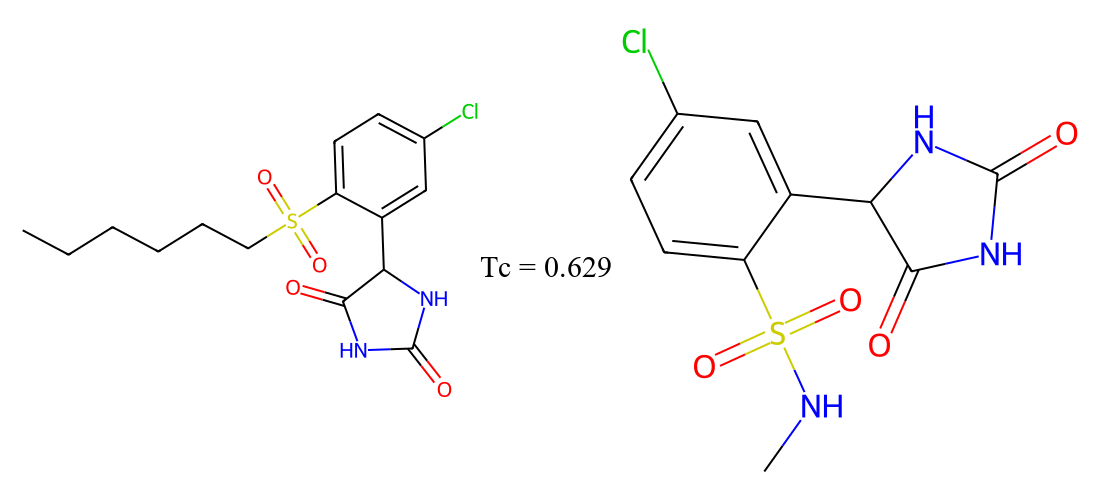

In [3]:
# Test in a kinase inhibitor
mol1 = Chem.MolFromSmiles("CCCCCCS(=O)(=O)c1ccc(Cl)cc1C1NC(=O)NC1=O")
mol2 = Chem.MolFromSmiles("CNS(=O)(=O)c1ccc(Cl)cc1C1NC(=O)NC1=O")
# Anchor the molecules to the same position
mol1 = Chem.RemoveHs(mol1)
mol2 = Chem.RemoveHs(mol2)
# AllChem.EmbedMolecule(mol1)
# AllChem.EmbedMolecule(mol2)
# AllChem.AlignMol(mol1, mol2)
# Get a big image
img1 = Draw.MolToImage(mol1, size=(500, 500))
img2 = Draw.MolToImage(mol2, size=(500, 500))
# Put both images together, leaving some space in the middle
img = Image.new('RGB', (1100, 500))
img.paste(img1, (0, 0))
img.paste(img2, (600, 0))
# Fill the space in the middle with a white rectangle
draw = ImageDraw.Draw(img)
draw.rectangle([(500, 0), (600, 500)], fill=(255, 255, 255))


# Compute the Tanimoto similarity between mol1 and mol2
fp1 = AllChem.GetMorganFingerprint(mol1, 2)
fp2 = AllChem.GetMorganFingerprint(mol2, 2)
similarity = DataStructs.TanimotoSimilarity(fp1, fp2)
# print(similarity)
# Annotate in the middle the Tanimoto similarity
d = ImageDraw.Draw(img)
d.text((480, 250), f"Tc ={similarity : .3f} ", 
       fill=(0, 0, 0), 
       font=ImageFont.truetype("times.ttf", 30))
img

## Parsing through folders:

In [4]:
# os.listdir('./batch1/CHEMBL1293255/')

df = pd.read_csv('data_cp.csv')

"""Now I will build a Dataframe with the SMILES of the first compund, the SMILES of the second compund, 
the pChEMBL value of each one, and the Tanimoto similarity between them."""

# First compare the tanimoto similarity between the first compound and the rest of the compounds

first_compound = df['Smiles'][0]

# Compare the first compound with the rest of the compounds
tanimoto_similarity = []
for i in range(1, len(df)):
    tanimoto_similarity.append(DataStructs.FingerprintSimilarity(Chem.RDKFingerprint(Chem.MolFromSmiles(first_compound)), Chem.RDKFingerprint(Chem.MolFromSmiles(df['Smiles'][i]))))

# Build the Dataframe
df_tanimoto = pd.DataFrame({'Smiles': df['Smiles'][1:], 'Tanimoto': tanimoto_similarity})

# Get only the compounds with a Tanimoto similarity greater than 0.9
df_tanimoto = df_tanimoto[df_tanimoto['Tanimoto'] > 0.9]

# 
df_tanimoto

,Smiles,Tanimoto
10,CC(C)S(=O)(=O)c1ccc(Cl)cc1C1NC(=O)NC1=O,0.929773
20,CCS(=O)(=O)c1ccc(Cl)cc1C1NC(=O)NC1=O,0.949393
21,CCCS(=O)(=O)c1ccc(Cl)cc1C1NC(=O)NC1=O,0.975709
22,CCCCCS(=O)(=O)c1ccc(Cl)cc1C1NC(=O)NC1=O,0.994939


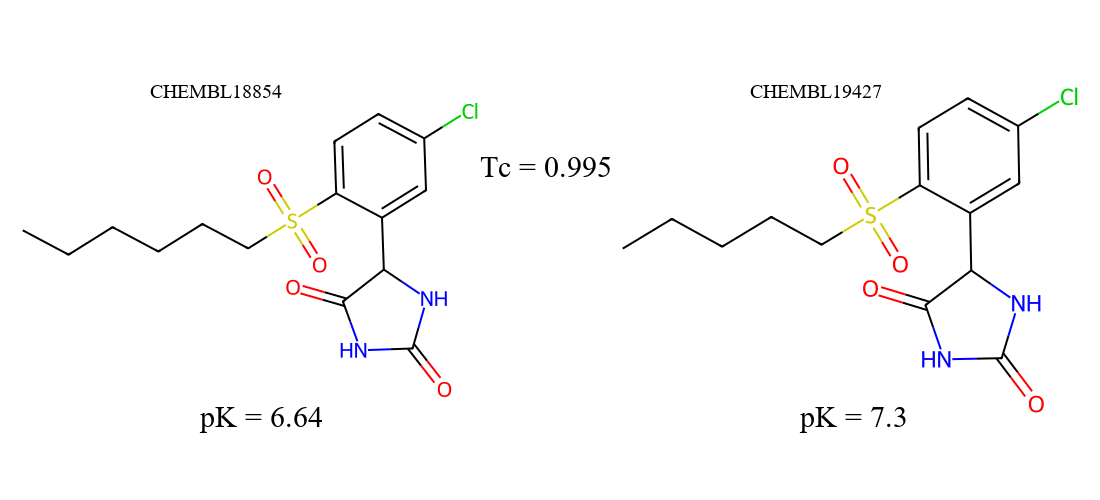

In [5]:
second = 22
mol1 = Chem.MolFromSmiles(df.Smiles[0])
mol2 = Chem.MolFromSmiles(df.Smiles[second])
# Fit both molecules to the same alignment
# AllChem.GenerateDepictionMatching2DStructure(mol1, mol2)

img1 = Draw.MolToImage(mol1, size=(500, 500))
img2 = Draw.MolToImage(mol2, size=(500, 500))
# Put both images together, leaving some space in the middle
img = Image.new('RGB', (1100, 500))
img.paste(img1, (0, 0))
img.paste(img2, (600, 0))
# Fill the space in the middle with a white rectangle
draw = ImageDraw.Draw(img)
draw.rectangle([(500, 0), (600, 500)], fill=(255, 255, 255))


# Compute the Tanimoto similarity between mol1 and mol2
fp1 = AllChem.RDKFingerprint(mol1, 2)
fp2 = AllChem.RDKFingerprint(mol2, 2)
similarity = DataStructs.TanimotoSimilarity(fp1, fp2)
# print(similarity)
# Annotate in the middle the Tanimoto similarity
d = ImageDraw.Draw(img)
d.text((480, 150), f"Tc ={similarity : .3f} ", 
       fill=(0, 0, 0), 
       font=ImageFont.truetype("times.ttf", 30))
# Annotate the pChEMBL value of each molecule, below the molecule
d.text((200, 400), f"pK = {df['pChEMBL Value'][0]}", 
       fill=(0, 0, 0), 
       font=ImageFont.truetype("times.ttf", 30))
d.text((800, 400), f"pK = {df['pChEMBL Value'][second]}", 
       fill=(0, 0, 0), 
       font=ImageFont.truetype("times.ttf", 30))

# Put the compound IDs on top
d.text((150, 80), f"{df['Compound_ID'][0]}", 
       fill=(0, 0, 0), 
       font=ImageFont.truetype("times.ttf", 20))
d.text((750, 80), f"{df['Compound_ID'][second]}", 
       fill=(0, 0, 0), 
       font=ImageFont.truetype("times.ttf", 20))
img

### Defining Functions to Conver and Save Images

In [6]:
def draw_AC_images(smiles_compound_1 = None, 
                   smiles_compound_2 = None, 
                   pK_compound_1 = 1,
                   pK_compound_2 = 1,
                   pChEMBL_compound_1 = None,
                   pChEMBL_compound_2 = None):
    """
    The function takes as input two SMILES strings, and two pK values, and creates an image
    with the two molecules, their pK values, and the Tanimoto similarity between them.

    Is it possible to create the Mol objects from the ChEMBL IDs?
    
    """
    mol1 = Chem.MolFromSmiles(smiles_compound_1)
    mol2 = Chem.MolFromSmiles(smiles_compound_2)
    img1 = Draw.MolToImage(mol1, size=(500, 500))
    img2 = Draw.MolToImage(mol2, size=(500, 500))
    # Put both images together, leaving some space in the middle
    img = Image.new('RGB', (1100, 500))
    img.paste(img1, (0, 0))
    img.paste(img2, (600, 0))
    # Fill the space in the middle with a white rectangle
    draw = ImageDraw.Draw(img)
    draw.rectangle([(500, 0), (600, 500)], fill=(255, 255, 255))


    # Compute the Tanimoto similarity between mol1 and mol2
    fp1 = AllChem.RDKFingerprint(mol1, 2)
    fp2 = AllChem.RDKFingerprint(mol2, 2)
    similarity = DataStructs.TanimotoSimilarity(fp1, fp2)
    # print(similarity)
    # Annotate in the middle the Tanimoto similarity
    d = ImageDraw.Draw(img)
    d.text((480, 150), f"Tc ={similarity : .3f} ", 
        fill=(0, 0, 0), 
        font=ImageFont.truetype("times.ttf", 30))
    # Annotate the pChEMBL value of each molecule, below the molecule
    d.text((200, 400), f"pK = {pK_compound_1}", 
        fill=(0, 0, 0), 
        font=ImageFont.truetype("times.ttf", 30))
    d.text((800, 400), f"pK = {pK_compound_2}", 
        fill=(0, 0, 0), 
        font=ImageFont.truetype("times.ttf", 30))

    # Put the compound IDs on top
    d.text((150, 80), f"{pChEMBL_compound_1}", 
        fill=(0, 0, 0), 
        font=ImageFont.truetype("times.ttf", 20))
    d.text((750, 80), f"{pChEMBL_compound_2}", 
        fill=(0, 0, 0), 
        font=ImageFont.truetype("times.ttf", 20))
    
    # Saving the image
    img.save(f'images/{pChEMBL_compound_1}_{pChEMBL_compound_2}.png')

    return None

# Testing the function 

smiles_compound_1 = df.Smiles[0]
smiles_compound_2 = df.Smiles[second]
pK_compound_1 = df['pChEMBL Value'][0]
pK_compound_2 = df['pChEMBL Value'][second]
pChEMBL_compound_1 = df['Compound_ID'][0]
pChEMBL_compound_2 = df['Compound_ID'][second]

draw_AC_images(smiles_compound_1, 
               smiles_compound_2, 
               pK_compound_1,
               pK_compound_2,
               pChEMBL_compound_1,
               pChEMBL_compound_2)


In [8]:
activities = new_client.activity.filter(molecule_chembl_id__in='CHEMBL3729567')

In [9]:
activities[0]['canonical_smiles']

'COCCN1C[C@@H]2[C@H](C1)[C@H]2c1cc(-c2cnc(N)c(C(F)(F)F)c2)nc(N2CC3CC2C3)n1'

In [ ]:
df['Smiles'].values.tolist()[0]==activities[0]['canonical_smiles']

True